# Simulating FEE on MC data

Develops the procedure to simulate the effect of FEE in NEXT MC data

In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import system_of_units as units
import tables
import mplFunctions as mpl
import wfmFunctions as wfm

In [3]:
import FEE as FE

In [4]:
import time

## Revised on:

In [5]:
print(time.strftime("%d/%m/%Y"))

01/11/2016


In [6]:
print(time.strftime("%H:%M:%S"))

20:30:11


###  Code exercized

In [7]:
!pep8 ../Sierpe/FEE.py

In [8]:
!pyflakes ../Sierpe/FEE.py

## SIMULATING THE EFFECT OF ELECTRONICS OVER MC DATA

### Monte Carlo data

1. Running on electrons of fixed energy (40, 1250, 2500 keV)  in the center of chamber.
2. Nominal yield factor in current NEW conditions (7 bar, 7 kV in gate) is 574 photons/e
3. Monte Carlo yield factor 690 photons/e

In [25]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


### PROCEDURE

1. Read MCRD (bins of 1 ns).
2. Convolute with SPE response to form a signal_i (units of A)
3. Decimate the signal.
4. Simulate the effect of the filter.

#### List the files

In [82]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5
electrons.1250.0keV.z250mm.next_10.root.h5
electrons.1250.0keV.z250mm.next_100.root.h5
electrons.1250.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10.root.h5
electrons.2500.0keV.z250mm.next_100.root.h5
electrons.2500.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10000.root.h5
electrons.40.0keV.z250mm.next_10.root.h5
electrons.40.0keV.z250mm.next_100.root.h5
electrons.40.0keV.z250mm.next_1000.root.h5
electrons.40.0keV.z250mm.next_10000.root.h5
run_2609_kr.root.h5


#### Open and inspect files

In [83]:
kr2609 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2609_kr.root.h5','r+')

In [84]:
kr2609

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2609_kr.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/RD (Group) ''
/RD/pmtblr (EArray(1365, 12, 48000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 48000)
/RD/pmtrwf (EArray(1365, 12, 48000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 48000)
/RD/sipmrwf (EArray(1365, 17

In [96]:
e2500 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.2500.0keV.z250mm.next_1000.root.h5','r+')

In [85]:
e1250 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.1250.0keV.z250mm.next_1000.root.h5','r+')

In [11]:
e40 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_1000.root.h5','r+')

#### loading the PMTRD vector: train of SPE in bins of 1 ns

In [13]:
pmtrd = e40.root.pmtrd

#### Plot pmtrd for the first event, first PMT

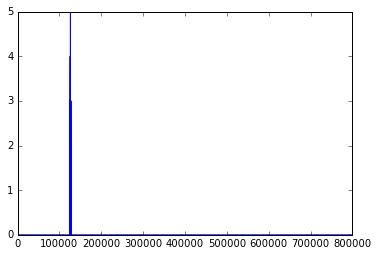

In [14]:
plt.plot(pmtrd[0,0])

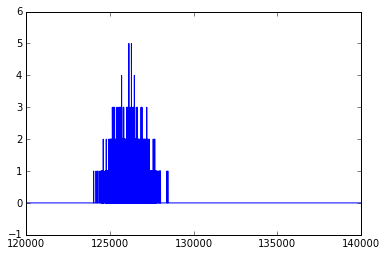

In [16]:
mpl.plts(pmtrd[0,0], signal_start=120000, signal_end=140000, offset=1)

In [17]:
print('area of kripton events in pe ={}'.format(np.sum(pmtrd[0,0])))

area of kripton events in pe =1210


#### signal_i : convolute pmtrd with spe

In [18]:
spe = FE.SPE()

In [19]:
spe


        (PMT gain = 4.5e+06, amplitude = 1.2e+02 muA
         slope =  5.00 ns, flat =  1.00 ns)
        

In [20]:
signal_i = FE.spe_pulse_from_vector(spe,pmtrd[0,0])  # in current units

#### Create FEE instance

In [21]:
fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)

In [22]:
fee


        (C1 =  2714.0 nf,
         C2 =     8.0 nf,
         R1 =  1567.0 ohm,
         Zin =    62.0 ohm,
         gain =   582.2 ohm,
         f_sample =    40.0 MHZ,
         freq_LHPF =   12.25 kHz,
         freq_LPF1 =    3.00 MHZ,
         freq_LPF2 =   10.00 MHZ,
         freq_LHPFd =  0.00061,
         freq_LPF1d =    0.15,
         freq_LPF2d =    0.50,
         noise_FEEPMB_rms =    0.54 muA,
         LSB =    0.39 mV,
         volts to adc = 0.00039,
         DAQnoise_rms =    0.31
        )
        

#### plot input function

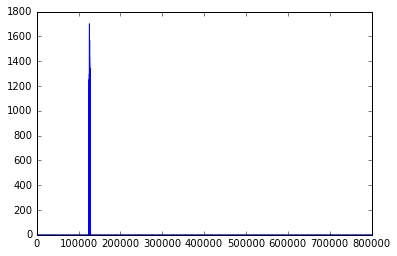

In [23]:
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(fee))   #plot input signal in adc counts

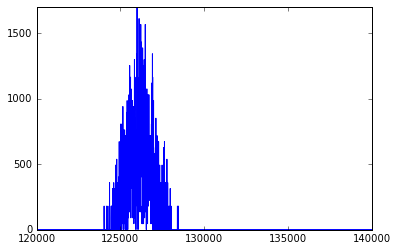

In [24]:
mpl.plts(signal_i*FE.i_to_adc(fee), signal_start=120000, signal_end=140000, offset=2)

### Decimate

#### sampling frequencies

In [27]:
f_sample1 = (1./(1*units.ns))

In [28]:
f_sample2 = (1./(25*units.ns))

In [29]:
f_sample1/units.MHZ

1000.0

In [30]:
f_sample2/units.MHZ

40.0

In [31]:
scale = int(f_sample1/f_sample2)

In [32]:
scale

25

### Decimation

In [43]:
signal_d = FE.daq_decimator(f_sample1, f_sample2, signal_i)

In [44]:
len(signal_i)

800000

In [45]:
len(signal_d)

32000

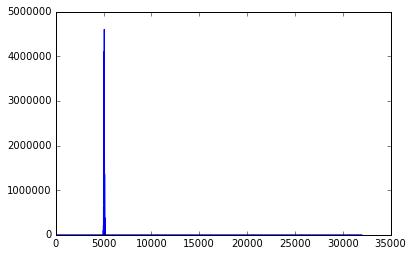

In [46]:
plt.plot(signal_d)

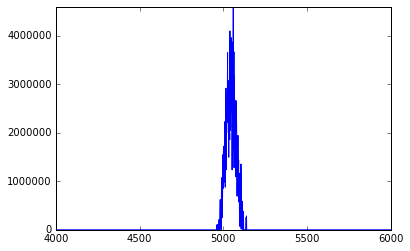

In [47]:
mpl.plts(signal_d, signal_start=4000, signal_end=6000, offset=2)

### Convolve with FEE

In [52]:
signal_fee = FE.signal_v_fee(fee, signal_d)*FE.v_to_adc(fee)  #in adc counts

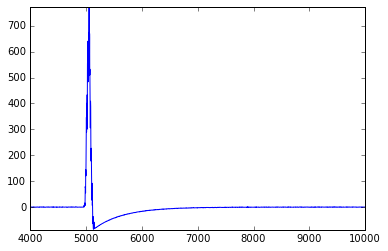

In [51]:
mpl.plts(signal_fee, signal_start=4000, signal_end=10000, offset=2)

### Remove the effect of filter

#### cleaning filter

In [53]:
signal_c = FE.signal_clean(fee, signal_fee)

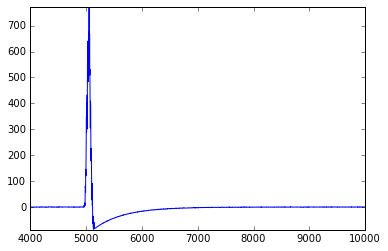

In [54]:
mpl.plts(signal_c, signal_start=4000, signal_end=10000, offset=2)

In [55]:
def deconv_simple(signal,coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0]=coef*signal[0]
    for n in np.arange(1,len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r, acum

In [56]:
signal_r, acum = deconv_simple(signal_c,coef=fee.freq_LHPFd*np.pi)

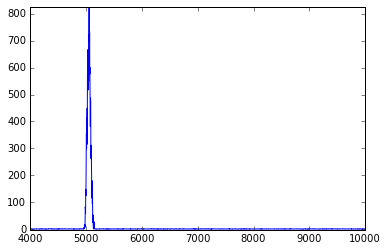

In [57]:
mpl.plts(signal_r, signal_start=4000, signal_end=10000, offset=2)

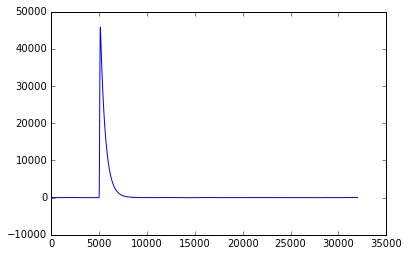

In [58]:
plt.plot(acum)

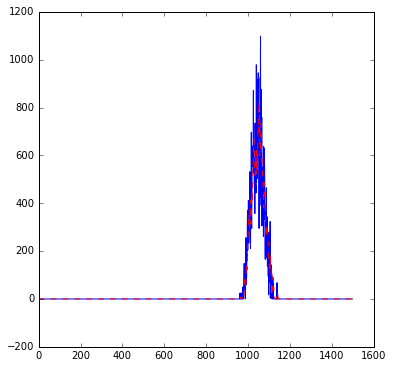

In [77]:
plt.figure(figsize=(6, 6))
plt.plot(signal_d[4000:5500]*FE.i_to_adc(fee))
plt.plot(signal_r[4000:5500],'r--', linewidth=1)
plt.show()

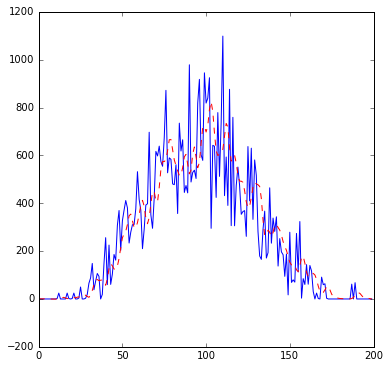

In [80]:
plt.figure(figsize=(6, 6))
plt.plot(signal_d[4950:5150]*FE.i_to_adc(fee))
plt.plot(signal_r[4950:5150],'r--', linewidth=1)
plt.show()

In [81]:
energy_mea=np.sum(signal_r[4950:5150])
energy_in=np.sum(signal_d[4950:5150]*FE.i_to_adc(fee))
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 52608.1507606
Reconstructed Energy = 52659.4724779
Error in Energy Computation (%) = -0.0975546880055


In [86]:
def fee_response(h5f, event=0, pmt=0):
    """
    returns:
    input function (after daq decimation)
    convoluted function (after FEE)
    recovered function (after cleaning filter and BLR)
    all in adc counts
    """
    pmtrd = h5f.root.pmtrd
    spe = FE.SPE()
    signal_i = FE.spe_pulse_from_vector(spe, pmtrd[event,pmt])  # in current units
    fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
    signal_d = FE.daq_decimator(FE.f_mc, FE.f_sample, signal_i)
    signal_fee = FE.signal_v_fee(fee, signal_d)*FE.v_to_adc(fee)  #in adc counts
    signal_c = FE.signal_clean(fee, signal_fee)
    signal_r, acum = deconv_simple(signal_c,coef=fee.freq_LHPFd*np.pi)
    
    return signal_d*FE.i_to_adc(fee), signal_fee, signal_r

In [87]:
signal_d, signal_fee, signal_r = fee_response(e1250, event=10, pmt=0)

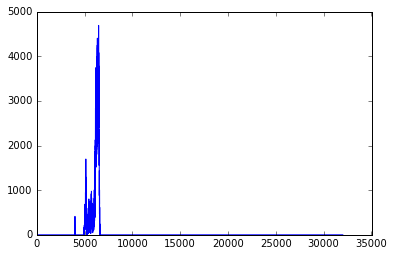

In [88]:
plt.plot(signal_d)

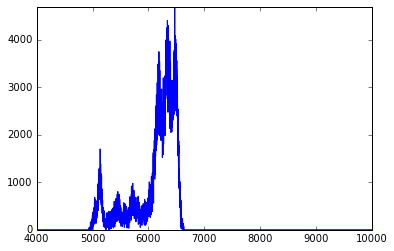

In [90]:
mpl.plts(signal_d, signal_start=4000, signal_end=10000, offset=2)

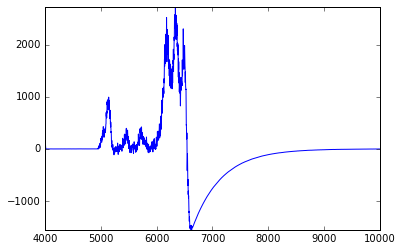

In [91]:
mpl.plts(signal_fee, signal_start=4000, signal_end=10000, offset=2)

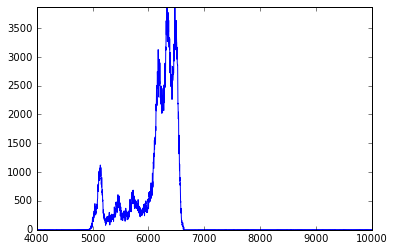

In [92]:
mpl.plts(signal_r, signal_start=4000, signal_end=10000, offset=2)

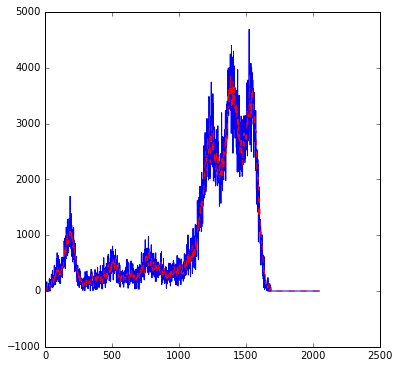

In [94]:
plt.figure(figsize=(6, 6))
plt.plot(signal_d[4950:7000])
plt.plot(signal_r[4950:7000],'r--', linewidth=1)
plt.show()

In [95]:
energy_mea=np.sum(signal_r[4950:7000])
energy_in=np.sum(signal_d[4950:7000])
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 1675713.79741
Reconstructed Energy = 1676137.64123
Error in Energy Computation (%) = -0.0252933297806


In [97]:
signal_d, signal_fee, signal_r = fee_response(e2500, event=100, pmt=0)

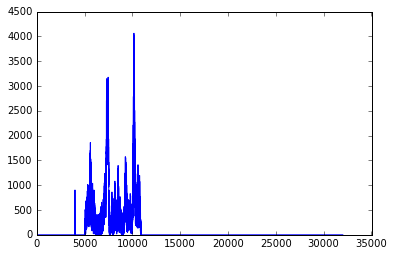

In [98]:
plt.plot(signal_d)

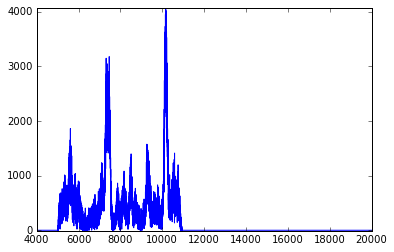

In [100]:
mpl.plts(signal_d, signal_start=4000, signal_end=20000, offset=10)

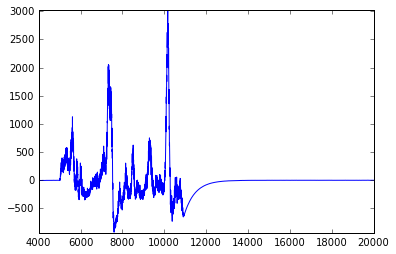

In [101]:
mpl.plts(signal_fee, signal_start=4000, signal_end=20000, offset=10)

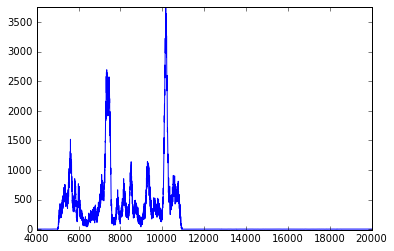

In [102]:
mpl.plts(signal_r, signal_start=4000, signal_end=20000, offset=10)

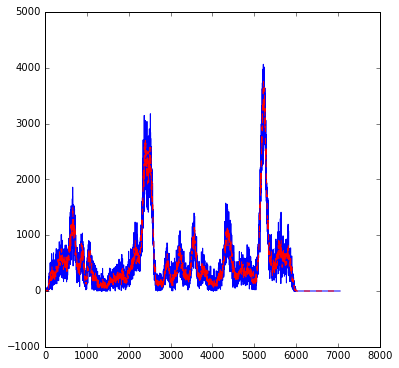

In [104]:
plt.figure(figsize=(6, 6))
plt.plot(signal_d[4950:12000])
plt.plot(signal_r[4950:12000],'r--', linewidth=1)
plt.show()

In [105]:
energy_mea=np.sum(signal_r[4950:12000])
energy_in=np.sum(signal_d[4950:12000])
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 3268050.48835
Reconstructed Energy = 3268092.18128
Error in Energy Computation (%) = -0.00127577385706
